In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from spikingjelly.clock_driven import functional, surrogate, neuron, layer
from spikingjelly.activation_based import spike_op as sn
from spikingjelly.activation_based import functional, surrogate, neuron, layer, encoding
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import cupy

In [104]:
time_steps = 8
batch_size = 16
learning_rate = 1e-3
epochs = 100

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the dataset
train_dataset = datasets.ImageFolder(
    root='./dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(
    root='./dataset/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [112]:
class CSNN(nn.Module):
    def __init__(self, T=8):
        super(CSNN, self).__init__()
        self.T = T
        self.layer1 = nn.Sequential(
            layer.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),
            layer.BatchNorm2d(128)
        )
        self.layer2 = nn.Sequential(
            neuron.IFNode(v_threshold=1.0, surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            layer.BatchNorm2d(128),
            neuron.IFNode(v_threshold=1.0, surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            layer.Flatten(),
            layer.Dropout(p=0.5),
            layer.Linear(128*12*12, 1152),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan()),
            layer.Dropout(p=0.5),
            layer.Linear(1152, 128),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan()),
            layer.Linear(128, 7),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan())
        )
        
        # functional.set_step_mode(self, step_mode='m')
        functional.set_backend(self, backend='torch')
        self.pe = encoding.PoissonEncoder()
    def forward(self, x):
        # x = self.pe(x)
        x = self.layer1(x)
        x_time = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        for t in range(self.T):
            x_time[t] = self.pe(x)
        x_step = []
        for t in range(self.T):
            out1 = self.layer2(x_time[t])
            out2 = self.layer3(out1)
            x_step.append(out2.unsqueeze(0))
        x = torch.cat(x_step) 
        return x.mean(dim=0)

In [113]:
def train(model, loader, optimizer, criterion, mse=False):
    model.train()
    total_loss, correct = 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if mse:
          target_onehot = torch.nn.functional.one_hot(target, num_classes=7).float()
          loss = criterion(output, target_onehot)
        else:
          loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        correct += (output.argmax(dim=1) == target).sum().item()
        functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def validate(model, loader, criterion,mse=False):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if mse:
              target_onehot = torch.nn.functional.one_hot(target, num_classes=7).float()
              loss = criterion(output, target_onehot)
            else:
              loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(dim=1) == target).sum().item()
            functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


# Initialize model, criterion, and optimizer
model = CSNN(T=4).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()

mse= True if criterion._get_name() == 'MSELoss' else False

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []
# Train and Validate
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion,mse=mse)
    val_loss, val_acc = validate(model, test_loader, criterion,mse=mse)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.4f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.4f}%")


Epoch 1: Train Loss: 1.8409, Train Acc: 21.0805%, Val Loss: 1.8213, Val Acc: 19.3926%
Epoch 2: Train Loss: 1.8143, Train Acc: 21.9618%, Val Loss: 1.8065, Val Acc: 21.5798%


KeyboardInterrupt: 

In [ ]:
# plot train and validation accuracy
import matplotlib.pyplot as plt
def plot_acc(train_acc_hist, val_acc_hist):
    plt.plot(train_acc_hist, label='Train Acc')
    plt.plot(val_acc_hist, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(train_loss_hist, val_loss_hist):
    plt.plot(train_loss_hist, label='Train Loss')
    plt.plot(val_loss_hist, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_acc(train_acc_hist, val_acc_hist)
plot_loss(train_loss_hist, val_loss_hist)

torch.Size([1, 1, 48, 48])


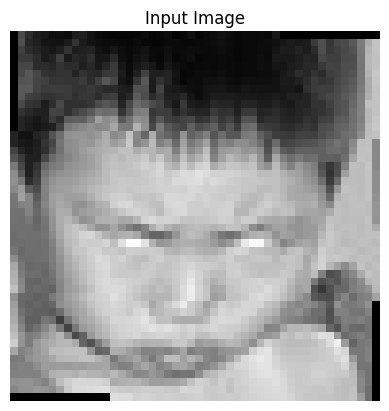

torch.Size([20, 1, 48, 48])


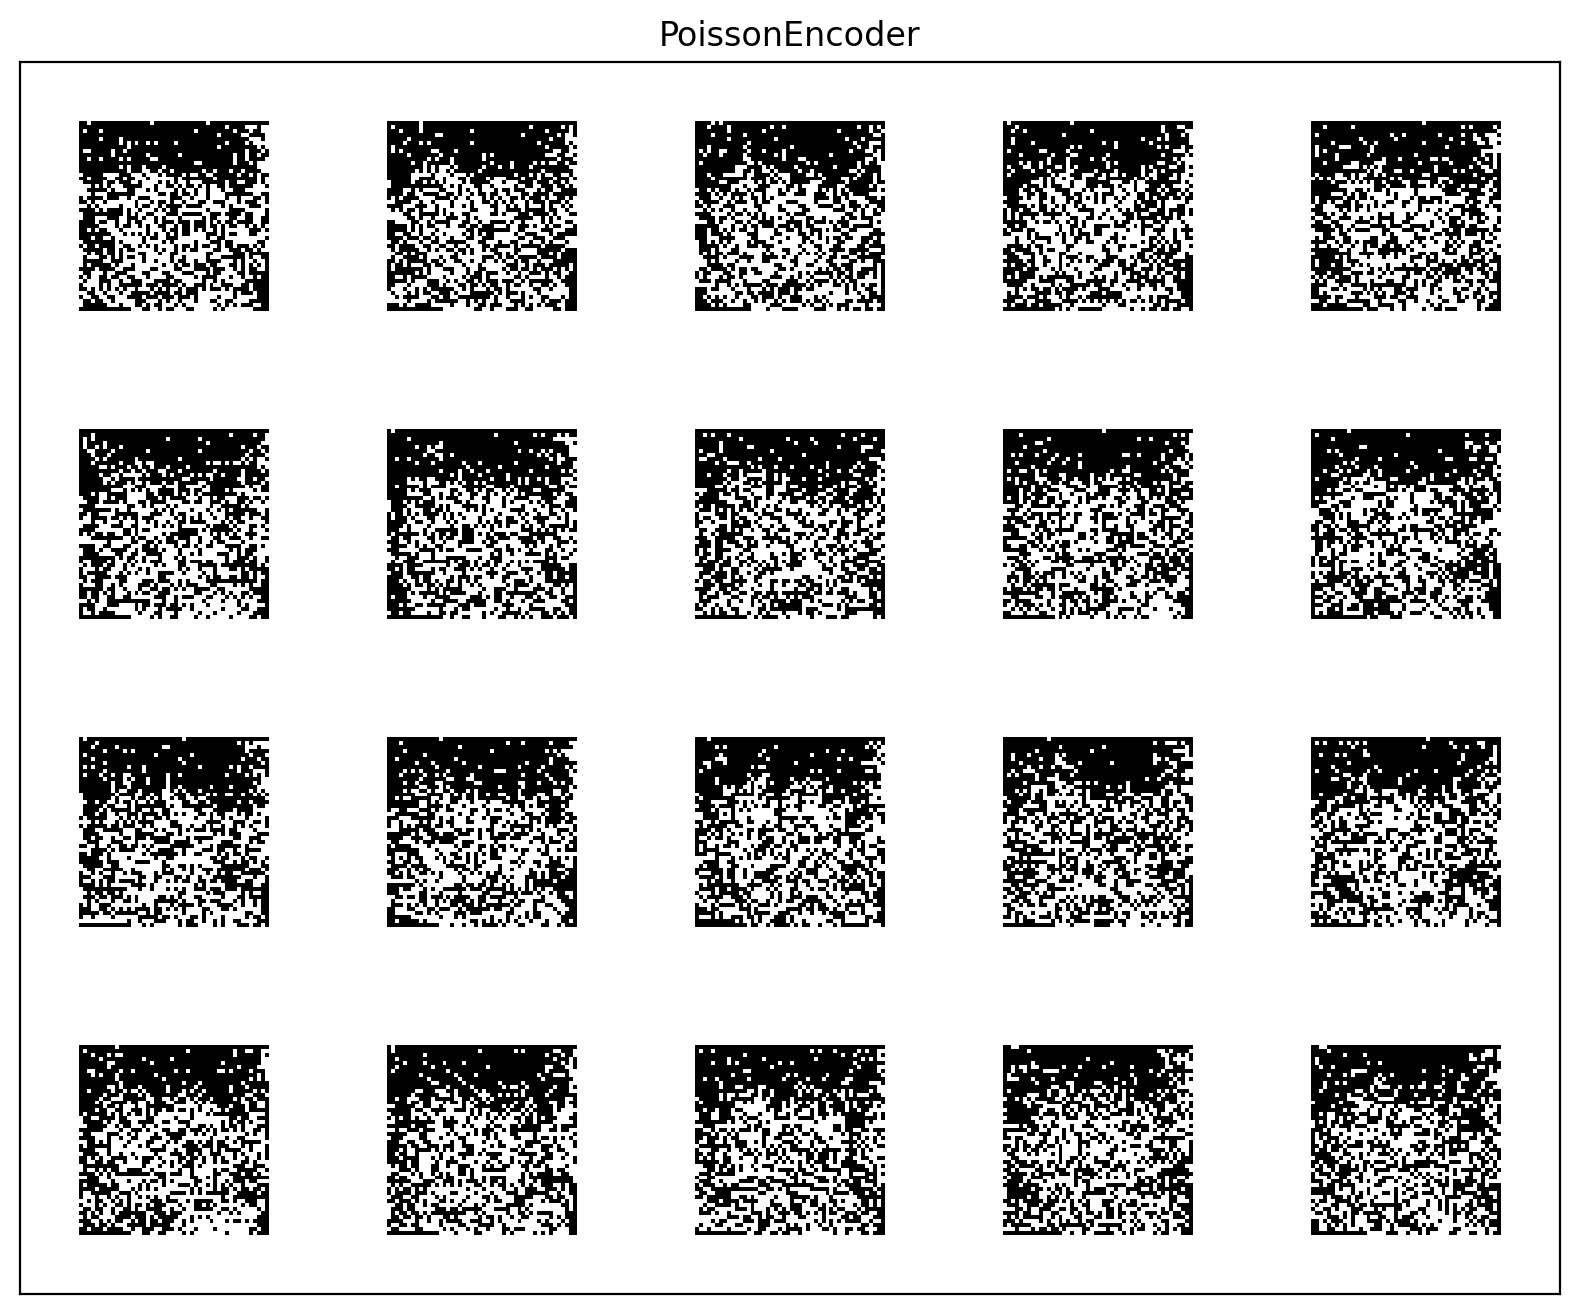

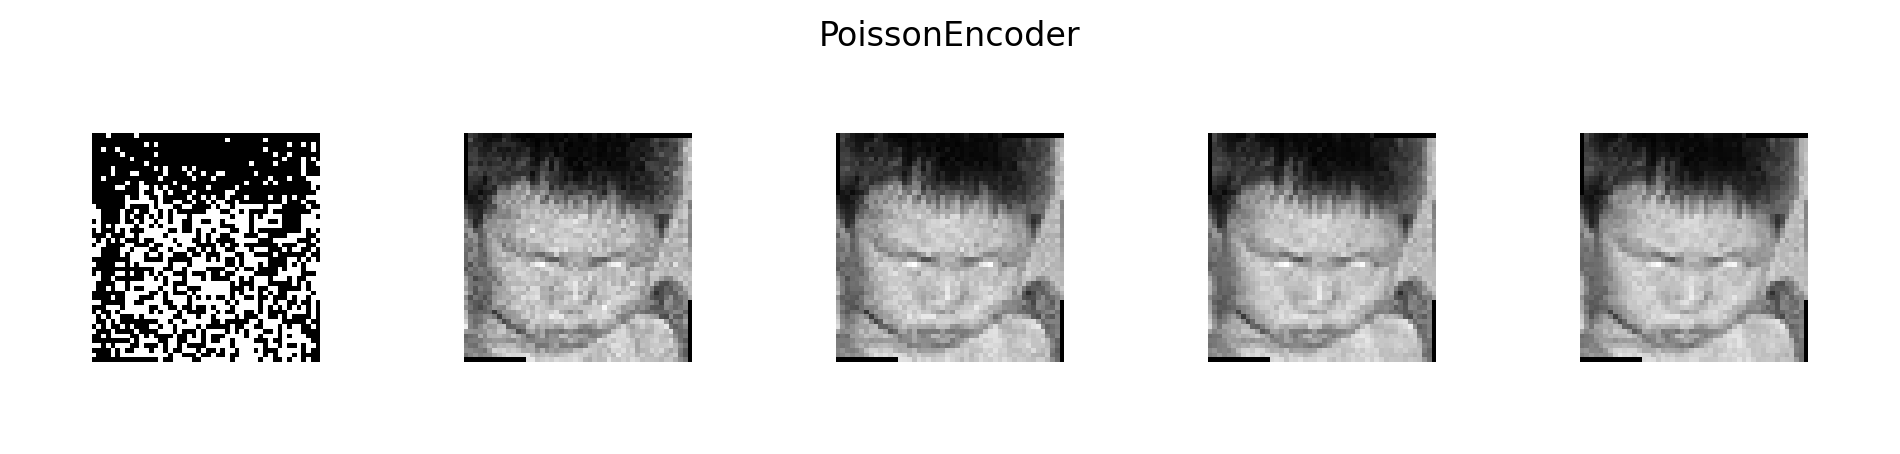

In [ ]:
from spikingjelly import visualizing

# Assuming the dataset is already loaded as `train_dataset` and `device` is set correctly
image = train_dataset[0][0].unsqueeze(0)


def original_img(img):
    plt.figure()    
    print(img.shape)
    # Display the first channel of the first image
    plt.imshow(img[0, 0].cpu().numpy(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.show()


# Poisson Encoder from Spiking Jelly
pe = encoding.PoissonEncoder()


def visualize_spike_train(image, time_step):
    out_spike = torch.full((time_step, 1, 48, 48), 0, dtype=torch.bool) # Initialize spike train tensor

    # Generate spike trains for each time step
    for t in range(time_step):
        out_spike[t] = pe(image)  # Apply Poisson encoding at each time step
    print(out_spike.shape)
    # Visualize the spike train at each time step
    visualizing.plot_2d_feature_map(
            out_spike.squeeze().float().numpy(), 4, 5, 30, 'PoissonEncoder')
        
def superimpose_spike_train(image):
    # Visualize the superposition of spike trains
    superposition = torch.full((48, 48), 0, dtype=torch.float)

    superposition_ = torch.full((5, 48, 48), 0, dtype=torch.float)
    T = 512
    for t in range(T):
        superposition += pe(image.squeeze()).float()
        if t == 0 or t == 127 or t == 255 or t == 387 or t == 511:
            superposition_[int((t + 1) / 128)] = superposition

    for i in range(5):
        min_ = superposition_[i].min()
        max_ = superposition_[i].max()
        superposition_[i] = (superposition_[i] - min_) / (max_ - min_)

    visualizing.plot_2d_feature_map(
        superposition_.numpy(), 1, 5, 30, 'PoissonEncoder')
    plt.axis('off')

    plt.show()


# Example: Visualizing spike train at time step 5
original_img(image)  # Display the original image
visualize_spike_train(image,time_step=20)  # Visualize spike train over 5 time steps
superimpose_spike_train(image)

In [20]:
torch.save(model.state_dict(), 'sjcnn.pth')